<a href="https://colab.research.google.com/github/alexjercan/depth-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

In [1]:
!git clone https://github.com/alexjercan/depth-estimation.git
%cd depth-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# Download model
torch.hub.download_url_to_file('https://github.com/alexjercan/depth-estimation/releases/download/v1.0/normal.pth', 'normal.pth')

In [9]:
# Download dataset stereo
!bash ./get_bdataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   4915      0 --:--:-- --:--:-- --:--:--  4915
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1262M    0 1262M    0     0  92.8M      0 --:--:--  0:00:13 --:--:--  111M
Completed in 39 seconds


In [10]:
!git pull
!python dataset.py
!python model.py

Already up to date.
dataset ok
model ok


In [16]:
import os
import re
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_stereo"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [{"imageL": "data/left.png", "imageR": "data/right.png", "output": "data/output.exr"}]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 0.01
BETAS = [0.9, 0.999]
EPS = 0.00000001
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.9
DAMPENING = 0.1

MILESTONES = [10,20,30]
GAMMA = 0.2

NUM_EPOCHS = 40
OUT_PATH ="./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [17]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        M.MyHorizontalFlip(p=0.5),
        M.MyVerticalFlip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
            M.MyIAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
    }
)

detect_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)


In [18]:
model = Model()
model.apply(init_weights)
solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                         lr=LEARNING_RATE, momentum=MOMENTUM,
                         dampening = DAMPENING, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [19]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()

  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 0, loss=(total:0.0711)
======DEPTH=======
MSE=0.0762	RMSE=0.2393	MAE=0.1249	ABS_REL=0.1879
DELTA1.02=0.2912	DELTA1.05=0.5808	DELTA1.10=0.7573
DELTA1.25=0.8899	DELTA1.25^2=0.9432	DELTA1.25^3=0.9608



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 1, loss=(total:0.0521)
======DEPTH=======
MSE=0.0326	RMSE=0.1710	MAE=0.0603	ABS_REL=0.1262
DELTA1.02=0.4752	DELTA1.05=0.8097	DELTA1.10=0.9254
DELTA1.25=0.9637	DELTA1.25^2=0.9790	DELTA1.25^3=0.9859



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 2, loss=(total:0.0599)
======DEPTH=======
MSE=0.0405	RMSE=0.1848	MAE=0.0620	ABS_REL=0.1330
DELTA1.02=0.5143	DELTA1.05=0.8451	DELTA1.10=0.9354
DELTA1.25=0.9651	DELTA1.25^2=0.9789	DELTA1.25^3=0.9852



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 3, loss=(total:0.0737)
======DEPTH=======
MSE=0.0305	RMSE=0.1607	MAE=0.0475	ABS_REL=0.1108
DELTA1.02=0.6250	DELTA1.05=0.9103	DELTA1.10=0.9605
DELTA1.25=0.9752	DELTA1.25^2=0.9841	DELTA1.25^3=0.9884



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 4, loss=(total:0.0404)
======DEPTH=======
MSE=0.0203	RMSE=0.1290	MAE=0.0398	ABS_REL=0.1004
DELTA1.02=0.5797	DELTA1.05=0.9298	DELTA1.10=0.9679
DELTA1.25=0.9798	DELTA1.25^2=0.9870	DELTA1.25^3=0.9908



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 5, loss=(total:0.0254)
======DEPTH=======
MSE=0.0230	RMSE=0.1370	MAE=0.0409	ABS_REL=0.1034
DELTA1.02=0.6044	DELTA1.05=0.9325	DELTA1.10=0.9669
DELTA1.25=0.9791	DELTA1.25^2=0.9869	DELTA1.25^3=0.9908



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 6, loss=(total:0.0380)
======DEPTH=======
MSE=0.0215	RMSE=0.1349	MAE=0.0343	ABS_REL=0.0989
DELTA1.02=0.8021	DELTA1.05=0.9526	DELTA1.10=0.9709
DELTA1.25=0.9802	DELTA1.25^2=0.9871	DELTA1.25^3=0.9906



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 7, loss=(total:0.0270)
======DEPTH=======
MSE=0.0160	RMSE=0.1184	MAE=0.0309	ABS_REL=0.0922
DELTA1.02=0.7491	DELTA1.05=0.9601	DELTA1.10=0.9753
DELTA1.25=0.9833	DELTA1.25^2=0.9893	DELTA1.25^3=0.9924



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 8, loss=(total:0.0443)
======DEPTH=======
MSE=0.0145	RMSE=0.1125	MAE=0.0301	ABS_REL=0.0900
DELTA1.02=0.7130	DELTA1.05=0.9605	DELTA1.10=0.9760
DELTA1.25=0.9836	DELTA1.25^2=0.9899	DELTA1.25^3=0.9929



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 9, loss=(total:0.0367)
======DEPTH=======
MSE=0.0134	RMSE=0.1107	MAE=0.0278	ABS_REL=0.0870
DELTA1.02=0.8021	DELTA1.05=0.9677	DELTA1.10=0.9767
DELTA1.25=0.9838	DELTA1.25^2=0.9894	DELTA1.25^3=0.9926



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 10, loss=(total:0.0193)
======DEPTH=======
MSE=0.0105	RMSE=0.1005	MAE=0.0163	ABS_REL=0.0762
DELTA1.02=0.9626	DELTA1.05=0.9734	DELTA1.10=0.9789
DELTA1.25=0.9854	DELTA1.25^2=0.9904	DELTA1.25^3=0.9932



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 11, loss=(total:0.0223)
======DEPTH=======
MSE=0.0102	RMSE=0.0997	MAE=0.0161	ABS_REL=0.0755
DELTA1.02=0.9627	DELTA1.05=0.9731	DELTA1.10=0.9789
DELTA1.25=0.9856	DELTA1.25^2=0.9906	DELTA1.25^3=0.9933



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 12, loss=(total:0.0249)
======DEPTH=======
MSE=0.0097	RMSE=0.0971	MAE=0.0156	ABS_REL=0.0717
DELTA1.02=0.9642	DELTA1.05=0.9745	DELTA1.10=0.9800
DELTA1.25=0.9863	DELTA1.25^2=0.9911	DELTA1.25^3=0.9937



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 13, loss=(total:0.0225)
======DEPTH=======
MSE=0.0101	RMSE=0.0991	MAE=0.0161	ABS_REL=0.0723
DELTA1.02=0.9622	DELTA1.05=0.9737	DELTA1.10=0.9796
DELTA1.25=0.9859	DELTA1.25^2=0.9909	DELTA1.25^3=0.9935



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 14, loss=(total:0.0187)
======DEPTH=======
MSE=0.0109	RMSE=0.0988	MAE=0.0158	ABS_REL=0.0745
DELTA1.02=0.9641	DELTA1.05=0.9742	DELTA1.10=0.9798
DELTA1.25=0.9860	DELTA1.25^2=0.9911	DELTA1.25^3=0.9937



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 15, loss=(total:0.0151)
======DEPTH=======
MSE=0.0094	RMSE=0.0957	MAE=0.0149	ABS_REL=0.0721
DELTA1.02=0.9644	DELTA1.05=0.9743	DELTA1.10=0.9797
DELTA1.25=0.9860	DELTA1.25^2=0.9909	DELTA1.25^3=0.9936



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 16, loss=(total:0.0174)
======DEPTH=======
MSE=0.0091	RMSE=0.0941	MAE=0.0146	ABS_REL=0.0732
DELTA1.02=0.9658	DELTA1.05=0.9750	DELTA1.10=0.9802
DELTA1.25=0.9864	DELTA1.25^2=0.9911	DELTA1.25^3=0.9937



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 17, loss=(total:0.0204)
======DEPTH=======
MSE=0.0093	RMSE=0.0950	MAE=0.0149	ABS_REL=0.0705
DELTA1.02=0.9656	DELTA1.05=0.9754	DELTA1.10=0.9806
DELTA1.25=0.9865	DELTA1.25^2=0.9911	DELTA1.25^3=0.9937



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 18, loss=(total:0.0220)
======DEPTH=======
MSE=0.0100	RMSE=0.0962	MAE=0.0155	ABS_REL=0.0729
DELTA1.02=0.9645	DELTA1.05=0.9745	DELTA1.10=0.9801
DELTA1.25=0.9864	DELTA1.25^2=0.9911	DELTA1.25^3=0.9937



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 19, loss=(total:0.0164)
======DEPTH=======
MSE=0.0101	RMSE=0.0960	MAE=0.0156	ABS_REL=0.0739
DELTA1.02=0.9657	DELTA1.05=0.9751	DELTA1.10=0.9805
DELTA1.25=0.9866	DELTA1.25^2=0.9912	DELTA1.25^3=0.9938



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 20, loss=(total:0.0262)
======DEPTH=======
MSE=0.0090	RMSE=0.0936	MAE=0.0136	ABS_REL=0.0734
DELTA1.02=0.9659	DELTA1.05=0.9753	DELTA1.10=0.9804
DELTA1.25=0.9865	DELTA1.25^2=0.9912	DELTA1.25^3=0.9938



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 21, loss=(total:0.0115)
======DEPTH=======
MSE=0.0111	RMSE=0.0960	MAE=0.0145	ABS_REL=0.0726
DELTA1.02=0.9674	DELTA1.05=0.9759	DELTA1.10=0.9809
DELTA1.25=0.9868	DELTA1.25^2=0.9914	DELTA1.25^3=0.9939



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 22, loss=(total:0.0265)
======DEPTH=======
MSE=0.0090	RMSE=0.0928	MAE=0.0134	ABS_REL=0.0718
DELTA1.02=0.9667	DELTA1.05=0.9753	DELTA1.10=0.9806
DELTA1.25=0.9866	DELTA1.25^2=0.9913	DELTA1.25^3=0.9939



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 23, loss=(total:0.0143)
======DEPTH=======
MSE=0.0102	RMSE=0.0950	MAE=0.0139	ABS_REL=0.0707
DELTA1.02=0.9669	DELTA1.05=0.9762	DELTA1.10=0.9812
DELTA1.25=0.9870	DELTA1.25^2=0.9915	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 24, loss=(total:0.0135)
======DEPTH=======
MSE=0.0090	RMSE=0.0935	MAE=0.0133	ABS_REL=0.0717
DELTA1.02=0.9667	DELTA1.05=0.9758	DELTA1.10=0.9808
DELTA1.25=0.9868	DELTA1.25^2=0.9914	DELTA1.25^3=0.9939



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 25, loss=(total:0.0419)
======DEPTH=======
MSE=0.0088	RMSE=0.0928	MAE=0.0132	ABS_REL=0.0714
DELTA1.02=0.9660	DELTA1.05=0.9755	DELTA1.10=0.9807
DELTA1.25=0.9867	DELTA1.25^2=0.9914	DELTA1.25^3=0.9939



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 26, loss=(total:0.0152)
======DEPTH=======
MSE=0.0087	RMSE=0.0919	MAE=0.0131	ABS_REL=0.0691
DELTA1.02=0.9674	DELTA1.05=0.9761	DELTA1.10=0.9810
DELTA1.25=0.9869	DELTA1.25^2=0.9915	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 27, loss=(total:0.0280)
======DEPTH=======
MSE=0.0119	RMSE=0.0957	MAE=0.0148	ABS_REL=0.0709
DELTA1.02=0.9674	DELTA1.05=0.9761	DELTA1.10=0.9812
DELTA1.25=0.9870	DELTA1.25^2=0.9915	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 28, loss=(total:0.0174)
======DEPTH=======
MSE=0.0089	RMSE=0.0929	MAE=0.0132	ABS_REL=0.0692
DELTA1.02=0.9673	DELTA1.05=0.9760	DELTA1.10=0.9810
DELTA1.25=0.9869	DELTA1.25^2=0.9915	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 29, loss=(total:0.0182)
======DEPTH=======
MSE=0.0088	RMSE=0.0926	MAE=0.0131	ABS_REL=0.0710
DELTA1.02=0.9679	DELTA1.05=0.9762	DELTA1.10=0.9811
DELTA1.25=0.9869	DELTA1.25^2=0.9915	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 30, loss=(total:0.0247)
======DEPTH=======
MSE=0.0090	RMSE=0.0932	MAE=0.0131	ABS_REL=0.0701
DELTA1.02=0.9679	DELTA1.05=0.9759	DELTA1.10=0.9811
DELTA1.25=0.9869	DELTA1.25^2=0.9915	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 31, loss=(total:0.0135)
======DEPTH=======
MSE=0.0095	RMSE=0.0934	MAE=0.0136	ABS_REL=0.0722
DELTA1.02=0.9672	DELTA1.05=0.9761	DELTA1.10=0.9811
DELTA1.25=0.9868	DELTA1.25^2=0.9914	DELTA1.25^3=0.9939



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 32, loss=(total:0.0163)
======DEPTH=======
MSE=0.0088	RMSE=0.0924	MAE=0.0130	ABS_REL=0.0703
DELTA1.02=0.9675	DELTA1.05=0.9760	DELTA1.10=0.9810
DELTA1.25=0.9869	DELTA1.25^2=0.9914	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 33, loss=(total:0.0109)
======DEPTH=======
MSE=0.0105	RMSE=0.0940	MAE=0.0139	ABS_REL=0.0720
DELTA1.02=0.9679	DELTA1.05=0.9758	DELTA1.10=0.9808
DELTA1.25=0.9867	DELTA1.25^2=0.9913	DELTA1.25^3=0.9938



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 34, loss=(total:0.0148)
======DEPTH=======
MSE=0.0087	RMSE=0.0920	MAE=0.0130	ABS_REL=0.0722
DELTA1.02=0.9669	DELTA1.05=0.9757	DELTA1.10=0.9808
DELTA1.25=0.9868	DELTA1.25^2=0.9914	DELTA1.25^3=0.9939



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 35, loss=(total:0.0142)
======DEPTH=======
MSE=0.0089	RMSE=0.0930	MAE=0.0131	ABS_REL=0.0696
DELTA1.02=0.9676	DELTA1.05=0.9761	DELTA1.10=0.9810
DELTA1.25=0.9868	DELTA1.25^2=0.9914	DELTA1.25^3=0.9939



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 36, loss=(total:0.0180)
======DEPTH=======
MSE=0.0086	RMSE=0.0915	MAE=0.0128	ABS_REL=0.0712
DELTA1.02=0.9676	DELTA1.05=0.9761	DELTA1.10=0.9811
DELTA1.25=0.9869	DELTA1.25^2=0.9915	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 37, loss=(total:0.0153)
======DEPTH=======
MSE=0.0106	RMSE=0.0943	MAE=0.0138	ABS_REL=0.0706
DELTA1.02=0.9685	DELTA1.05=0.9764	DELTA1.10=0.9812
DELTA1.25=0.9870	DELTA1.25^2=0.9915	DELTA1.25^3=0.9940



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 38, loss=(total:0.0154)
======DEPTH=======
MSE=0.0092	RMSE=0.0930	MAE=0.0133	ABS_REL=0.0724
DELTA1.02=0.9666	DELTA1.05=0.9756	DELTA1.10=0.9808
DELTA1.25=0.9868	DELTA1.25^2=0.9914	DELTA1.25^3=0.9939



100%|██████████| 306/306 [02:44<00:00,  1.86it/s, epoch=39, loss=(total:0.0153)]

eval_avg_error
Epoch: 39, loss=(total:0.0153)
======DEPTH=======
MSE=0.0088	RMSE=0.0918	MAE=0.0129	ABS_REL=0.0703
DELTA1.02=0.9679	DELTA1.05=0.9764	DELTA1.10=0.9813
DELTA1.25=0.9871	DELTA1.25^2=0.9916	DELTA1.25^3=0.9940



In [20]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 153/153 [00:25<00:00,  5.95it/s]

eval_avg_error
Epoch: 39, loss=(total:0.0218)
======DEPTH=======
MSE=0.0097	RMSE=0.0964	MAE=0.0134	ABS_REL=0.0517
DELTA1.02=0.9680	DELTA1.05=0.9758	DELTA1.10=0.9807
DELTA1.25=0.9866	DELTA1.25^2=0.9911	DELTA1.25^3=0.9937



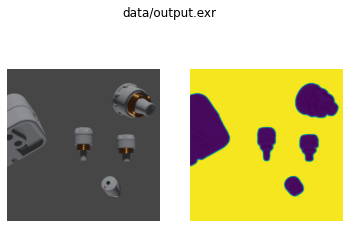

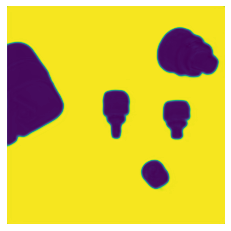

In [21]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, path in generatePredictions(model, images):
    plot_predictions([img], predictions, [path])
    save_predictions(predictions, [path])

In [22]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)